# 초기화 및 Kaggle에서 데이터수집


In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
creds = '{"username":"inaff0109","key":""}' # json파일은 가상에서 root/.kaggle 안에 넣어두도록 하자

In [ ]:
cred_path = Path('/root/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write(creds)
  cred_path.chmod(0o600)

In [ ]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [ ]:
Path.BASE_PATH = path

In [ ]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 48.4M/48.4M [00:01<00:00, 25.6MB/s]


(#7) [Path('Machine_Appendix.csv'),Path('Test.csv'),Path('TrainAndValid.csv'),Path('Valid.csv'),Path('ValidSolution.csv'),Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv')]

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [ ]:
# 순서형 열
# 저장된 문서열 값이 자연스러운 순서가 되도록 보장

df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [ ]:
productsize = 'ProductSize'
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df[productsize] = df[productsize].astype('category')
df[productsize].cat.set_categories(sizes, ordered=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [ ]:
# 평가지표를 구성하는 것은 매우 중요하다.
# 우리가 예측하는 것은 종속변수인데 어떤 평가지표인지 알아야 모델의 품질을 측정할 수 있기 때문이다.
# 평가지표를 선택하는 것은 프로젝트 구상에 있어서 중요한 부분을 차지하며, 평가지표로 표현될 만한 변수가 없다면 가용변수의 조합이나 변형으로 평가지표를 만들 수 있을지 고려해야 한다.

# 이번 대회에서는 평균제곱근로그오차 RMSLE를 사용하였으며 log를 구하고 m_rmse를 적용함녀 최종적인 RMSLE를 얻을 수 있다

dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])
df[dep_var]

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259131
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 412698, dtype: float64

# 결정트리

결정트리는 일련의 이진 질문을 던지고 예, 아니오로 분할되어 계속해서 가지를 뻗어나간다.

분기점을 만들고 계속해서 두 개로 분류하고 재귀적으로 반복하는데 특정기준(사용자의 선택)에 따라\
종료할 수 있다.

In [ ]:
# 날짜는 순서형 자료긴 하지만 특정 날짜는 다른 날짜보다 모델링하는 시스템에 연관되어 질적으로 다룰 수 있다는 점에서 일반적인 것과 다르다

# 메타데이터로 확장 -> 범주형 데이터를 제공

df = add_datepart(df, 'saledate')

In [ ]:
df

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,...,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,...,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,...,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,...,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,...,False,False,False,1.248307e+09
...,...,...,...,...,...,...,...,...,...
412693,6333344,9.210340,1919201,21435,...,False,False,False,1.331078e+09
412694,6333345,9.259131,1882122,21436,...,False,False,False,1.327709e+09
412695,6333347,9.433484,1944213,21435,...,False,False,False,1.327709e+09
412696,6333348,9.210340,1794518,21435,...,False,False,False,1.331078e+09


In [ ]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [ ]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [ ]:
# 문자열과 누락된 데이터를 다루는 일

# fastai의 TabularPandas 클래스를 사용한다.
# Categorify는 범주형 열을 수치형 열로 변형, FillMissing은 누락된 값을 해당열의 중앙값으로 넣고, 누락되어있었는지를 표시하는 열을 추가하여 누락된 행에다가 True를 기입

procs = [Categorify, FillMissing]


In [ ]:
# 학습용, 검증용, 테스트 셋의 상관관계

# 이 모델의 목적은 미래 예측에 달려있기 때문에 학습용과 검증용을 분리할 때에는 전체 데이터에서 일정 기간을 정해두고 전에 있는 것을 학습용,
# 기간 뒤에 있는 것(미래라고 가정)을 검증용

# 2011년 10월을 기준으로 이전에 있는 걸 학습, 이후의 것을 검증으로 쓴다.
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
train_idx, valid_idx

(array([     0,      1,      2, ..., 412695, 412696, 412697]),
 array([ 22915,  22916,  22917, ..., 401122, 401123, 401124]))

In [ ]:
splits = (list(train_idx), list(valid_idx))

In [ ]:
# tabularpandas객체를 생성할 때는 계속형 및 범주형 열의 목록을 알려줘야 합니다.

cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
cont, cat # cont 계속형, cat 범주형

(['SalesID',
  'MachineID',
  'ModelID',
  'datasource',
  'auctioneerID',
  'YearMade',
  'MachineHoursCurrentMeter',
  'saleYear',
  'saleMonth',
  'saleWeek',
  'saleDay',
  'saleDayofweek',
  'saleDayofyear',
  'saleElapsed'],
 ['UsageBand',
  'fiModelDesc',
  'fiBaseModel',
  'fiSecondaryDesc',
  'fiModelSeries',
  'fiModelDescriptor',
  'ProductSize',
  'fiProductClassDesc',
  'state',
  'ProductGroup',
  'ProductGroupDesc',
  'Drive_System',
  'Enclosure',
  'Forks',
  'Pad_Type',
  'Ride_Control',
  'Stick',
  'Transmission',
  'Turbocharged',
  'Blade_Extension',
  'Blade_Width',
  'Enclosure_Type',
  'Engine_Horsepower',
  'Hydraulics',
  'Pushblock',
  'Ripper',
  'Scarifier',
  'Tip_Control',
  'Tire_Size',
  'Coupler',
  'Coupler_System',
  'Grouser_Tracks',
  'Hydraulics_Flow',
  'Track_Type',
  'Undercarriage_Pad_Width',
  'Stick_Length',
  'Thumb',
  'Pattern_Changer',
  'Grouser_Type',
  'Backhoe_Mounting',
  'Blade_Type',
  'Travel_Controls',
  'Differential_Type',
  

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
# procs = [Categorify, FillMissing]

In [ ]:
# fastai의 데이터셋 객체와 비슷하게 작동한다

len(to.train), len(to.valid)

(404710, 7988)

In [ ]:
to.show(3)
# 출력에만 문자열로 표시는 되나

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [ ]:
# 실제로는 숫자로 저장된다. (임베딩)
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [ ]:
to.classes[productsize]

# 위의 자료에는 0,3,0으로 되어있는데 이는 순서가 정해진 범주에 따라 na, large / medium , na 인 것을 알 수 있다.


['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [ ]:
# 결과 저장하기 위해 피클 사용
save_pickle(path/'to.pkl',to)

In [ ]:
# load는 다음과 같다
to = load_pickle(path/'to.pkl')

# 결정트리 만들기

In [ ]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [ ]:
y # 종속변수

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259130
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 404710, dtype: float32

In [ ]:
# 결정트리 만들고 데이터를 맞추기
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

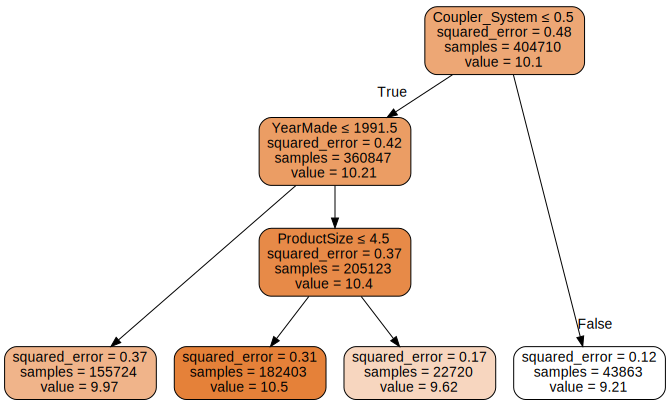

In [ ]:
# 노드를 만들고 결정트리가 학습한 내용을 시각화
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)
# squared_error와 MSE는 같다

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


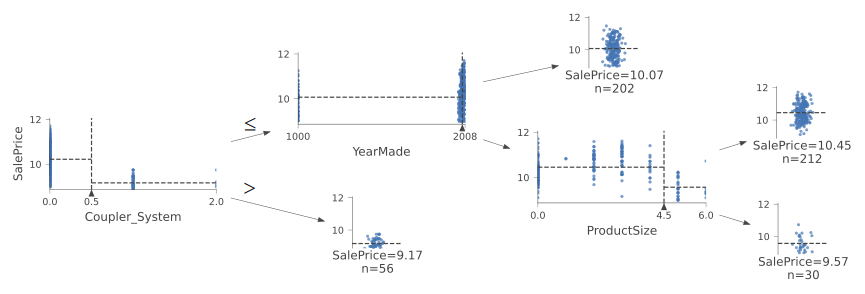

In [ ]:
samp_idx = np.random.permutation(len(y))[:500] # len(y) = 404710 개 만큼의 순열을 랜덤으로 배열하되 거기서 500개만 samp_idx로 할당한다
# samp_idx.shape 500
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, # dep_var 
         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
         orientation='LR')

# TRUE는 상향으로 False는 하향으로

# yearmade의 좌측을 보면 1000천년도에 만들어진 데이터가 있음을 확인할 수 있다. 명백한 데이터 오류

In [ ]:
xs['YearMade']<1900 # True or False 반환
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950 # 행과 열의 조합
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


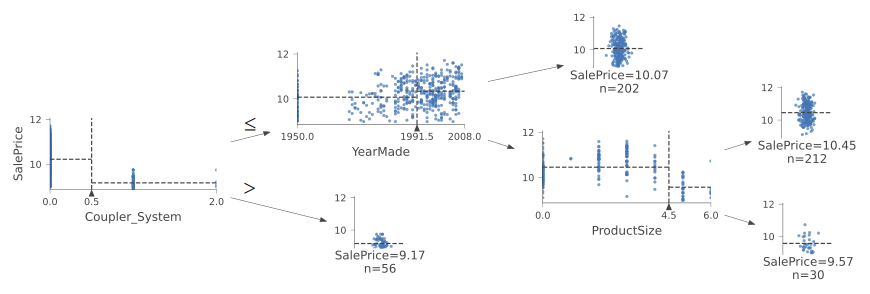

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
         fontname='DejaVu Sans', scale=1.6, label_fontsize = 10, orientation='LR')

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6) # 제곱평균제곱근 6자리까지 남기고 절삭
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y) # 모델의 예측


In [ ]:
m_rmse(m, xs, y) # 학습용에서는 차이가 없음을 확인

0.0

In [ ]:
m_rmse(m, valid_xs, valid_y) # 검증용에서 차이가 나는 것을 확인

0.334935

In [ ]:
m.get_n_leaves(), len(xs) # leaf 노드의 개수가 전체 데이터 개수만큼 존재

(324560, 404710)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y) # 합리적인 오차가 도출됨

(0.248593, 0.323339)

In [ ]:
m.get_n_leaves() # 34만개에서 1.2만개로 줄어들었다.

12397

# 랜덤포레스트

배깅 : 전체 데이터 중 임의의 부분집합을 고른다.

고른 집합을 가지고 모델에 학습시키는데 그 모델을 저장하고, 다시 같은 모델을 가지고 다른 부분집합을 가지고 학습한다.

그렇게 해서 학습된 모델들을 가지고 예측을 집계해 평균을 구하는 방식으로 전체 예측을 계산한다.


배깅과 같은 학습법을 통해 트리도 여러 개로 나누어 숲을 구성할 수 있는데 이때 임의의 행에서 그치는 것이 아니라, 임의의 열까지 선택하는 방식도 존재한다.

그렇게 트리의 도출된 예측 중 평균값을 구해 모델의 결과를 결합하는 앙상블의 방식이다.

In [ ]:
def rf(xs, y, n_estimators=40, # 트리의 개수
       max_samples=200_000, # 트리가 학습에 사용할 샘플 행의 수
       max_features=0.5, # 분할 지점마다 사용될 열의 개수를 정하는 인자
       min_samples_leaf=5, # 깊이에 한계를 주어 각 트리가 분할을 멈춰야 하는 시점을 정함
       **kwargs):
  return RandomForestRegressor(n_jobs = -1, # 모든 연산을 cpu가 병렬로 트리를 생성하라고 지시하는 용도
                               n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,
                               min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)

m = rf(xs, y)

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y) # 오차가 줄어든 것을 확인할 수 있다.

(0.170966, 0.232699)

In [ ]:
# max_features과 같은 하이퍼파라미터 선택에 크게 민감하지 않다는 ㅈ머이 중요하다
# n_estimators를 높게 설정해 트리를 더 많이 만들면 더 정확한 평균을 구할 수 있다.
# max_samples는 보통 default값으로 두지만 200,000이 넘어가면 200,000으로 설정하는게 정확도에 영향없다.

# 특징을 적게 사용하되 많은 트리를 배정하면 낮은 오차를 얻을 수 있다.


# 개별트리의 예측(estimators_)로 값을 확인하기

preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

m.estimators_[1].predict(valid_xs) # 첫번째 트리의 모델을 가지고 valid_xs를 예측한다.

# sklearn.tree.DecisionTreeClassifier 참고

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

array([10.30419226, 10.03128211,  9.5554491 , ...,  9.47595533,  9.04827287,  9.04827287])

In [ ]:
preds.mean(0) # column에 대한 모든 행의 평균을 구한다. 
r_mse(preds.mean(0), valid_y) # 제곱평균제곱근

0.232699

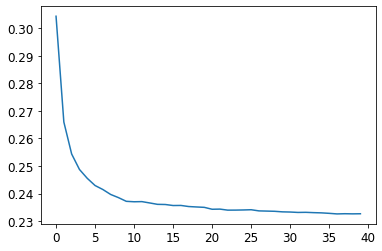

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

# OOB (out of bag) 오차

랜덤 포레스트의 각 트리는 학습용 데이터에서 서로 다른 부분집합에 의해 학습하는데

oob 오차는 학습용 데이터 중 참가하지 않은 행(데이터)를 이용하여 예측의 오차를 측정한다.

만약 과적합이 일어난 모델의 경우 엄청난 오차를 나타낼 것이다.

개인적으로는 학습용 데이터 안에 있는 검증용 데이터 셋이라 생각하면 편할 것 같다.

=> 학습용 데이터셋이 적을 때 검증용 데이터셋을 생성하기 위해 일부를 제거하지 않아도 일반화 가능

In [ ]:
r_mse(m.oob_prediction_, y)

# 평균 오차값보다 더 낮다. 다른 오차를 유발하는 원인이 존재

0.210776

# Model interpretation

* 예측 결과를 얼마나 신뢰할 수 있는지
* 가장 중요한 요소가 무엇이며 예측에 어떤 영향을 주는지
* 가장 영향력 있는 열은 무엇이며 , 어떤 열은 무시해도 좋은지
* 중복효과가 있는 열
* 열의 포함범위를 바꾸면 결과는 달라지는지?

In [ ]:
# 신뢰도를 구하는 법
# 트리 전체의 예측의 표준편차로 상대적인 신뢰를 확인

preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

preds.shape # 40개의 트리에 대해 검증용 데이터값을 각각 결과를 낸 것과 같다

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

(40, 7988)

In [ ]:
# preds.shape # 40, 7988
preds_std = preds.std(0)
preds_std.shape # (7988)

preds_std[:5] # 처음 다섯 개의 경매가

array([0.26069358, 0.10409366, 0.09904178, 0.27184634, 0.13110276])

In [ ]:
# 특징 중요도라는 예측을 수행하는 방법에 대해 통찰하는 사이킷 런의 속성

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

# yearmade와 productsize가 중요함을 나타냄

,cols,imp
57,YearMade,0.173023
6,ProductSize,0.117253
30,Coupler_System,0.117053
7,fiProductClassDesc,0.073112
54,ModelID,0.054777
65,saleElapsed,0.048835
3,fiSecondaryDesc,0.046104
31,Grouser_Tracks,0.041196
12,Enclosure,0.040495
32,Hydraulics_Flow,0.032725


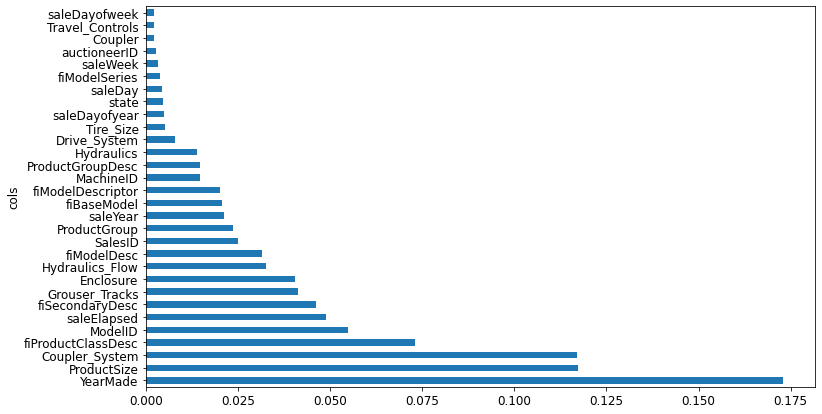

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

In [ ]:
# 중요도 낮은 변수를 제거해서 학습시켜보기

to_keep = fi[fi.imp>0.005].cols # 중요도가 0.005 이상인 컬럼들을 가지고 컬럼만을 들고온다.
len(to_keep)

21

In [ ]:
# 열 집합만 가지고 학습

xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.18131, 0.230503)

In [ ]:
# 더 적은 열을 사용해도 정확도는 같다

len(xs.columns), len(xs_imp.columns)

(66, 21)

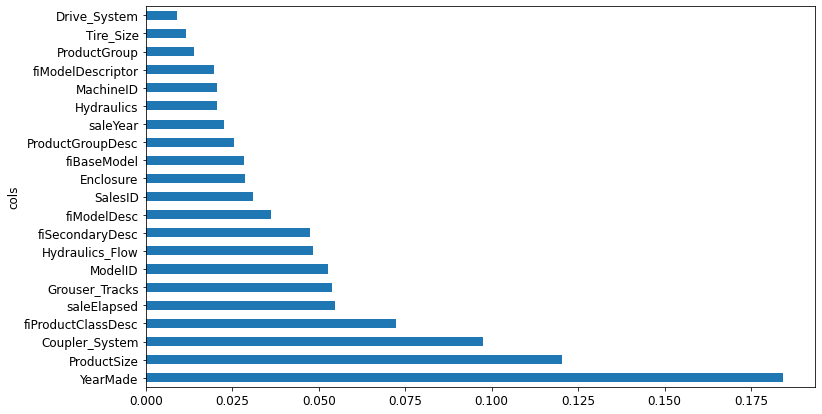

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp))

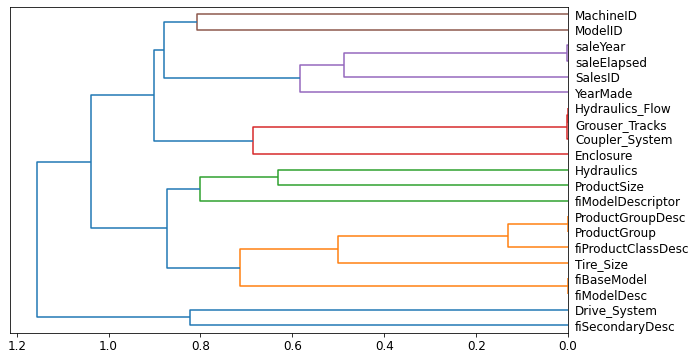

In [ ]:
# 중복특징 제거하기

cluster_columns(xs_imp)

In [ ]:
def get_oob(df):
  m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                            max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
  m.fit(df, y)
  return m.oob_score_

In [ ]:
get_oob(xs_imp)

0.8781576734893485

In [ ]:
# 하나씩 삭제하고 oob 분석
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8768628311464004,
 'saleElapsed': 0.8722097904682757,
 'ProductGroupDesc': 0.8770087512874477,
 'ProductGroup': 0.8778594920344923,
 'fiModelDesc': 0.8754781084425128,
 'fiBaseModel': 0.8761168180455399,
 'Hydraulics_Flow': 0.8774995916903535,
 'Grouser_Tracks': 0.8775565092698138,
 'Coupler_System': 0.8770165273393064}

In [ ]:
# 여러 변수를 삭제 후 확인

to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8750482697068109

In [ ]:
# 데이터프레임을 최종적으로 만들고 저장

xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [ ]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')